In [113]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [231]:
files = os.listdir()
csv_files = [file for file in files if file.endswith(".csv")]

sns.set(style="whitegrid")

In [232]:
combined_dataframes = {}

# Define the locations you want to process
locations = ["Plaza Singapura", "Raffles City"]

for location in locations:
    # Filter only the file names for the current location
    location_files = [file for file in csv_files if location in file]
    
    # Initialize an empty list to store dataframes
    dataframes = []

    # Loop through the location-specific CSV files and read them into dataframes
    for file_name in location_files:
        df = pd.read_csv(file_name)
        dataframes.append(df)

    # Concatenate the dataframes into a single dataframe for the current location
    combined_df = pd.concat(dataframes, axis=0, ignore_index=True)
    
    # Store the combined dataframe in the dictionary with the location name as the key
    combined_dataframes[location] = combined_df


In [239]:
combined_data = pd.DataFrame()

for location, location_df in combined_dataframes.items():
    combined_data = pd.concat([combined_data, location_df])

    combined_data["timestamp"] = pd.to_datetime(
        combined_data["timestamp"], dayfirst=True
    )
    combined_data["time"] = combined_data["timestamp"].dt.strftime("%d-%m-%Y %H:%M")
    combined_data["timestamp"] = combined_data["timestamp"]

    grouped_data = combined_data.groupby("name")

In [240]:
avg_df = pd.DataFrame()
i = 1

for _, data in grouped_data:
    if "time" not in avg_df.columns:
        avg_df["time"] = data["time"]
    avg_df["carparkOccupancy" + str(i)] = data["carparkOccupancy"]
    i += 1
    

avg_df.set_index("time", inplace=True)  
carparkOcc_cols = [col for col in avg_df.columns if "carparkOccupancy" in col]
avg_df["carparkOccupancy_mean"] = avg_df[carparkOcc_cols].mean(axis=1).astype(int)


In [ ]:
plt.figure(figsize=(15, 6))
for group, data in grouped_data:
    plt.plot(
        data["time"],
        data["carparkOccupancy"],
        "-",
        lw=2,
        label=f"{group}",
    )

plt.plot(
    avg_df.index,
    avg_df["carparkOccupancy_mean"],
    "-",
    lw=2,
    label="Average Occupancy",
    color="black",
)

ax = plt.gca()
loc = plticker.MultipleLocator(base=180.0)
ax.xaxis.set_major_locator(loc)

plt.xlabel("Time")
plt.ylabel("Carpark Occupancy")
plt.title("Carpark Occupancy Over Time")
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### Combined all the dates into single df to find the average based on that few days

In [299]:
locations = ["Plaza Singapura", "Raffles City"]

df_mean_list = {}

for location in locations:
    location_files = [file for file in csv_files if location in file]

    combined_df = pd.DataFrame()
    for file in location_files:
        df = pd.read_csv(file)
        df["timestamp"] = pd.to_datetime(
            df["timestamp"], dayfirst=True
        )
        df["timestamp"] = df["timestamp"].dt.strftime("%H:%M")
        combined_df = pd.concat([combined_df, df])

    # Group the combined DataFrame by "timestamp" and calculate the mean of "carOccupancy"
    mean_car_occupancy = round(combined_df.groupby("timestamp")["carparkOccupancy"].mean())
    
    df_mean_list[location] = pd.DataFrame(mean_car_occupancy)


In [321]:
# Concatenate the DataFrames in df_mean_list along the columns (axis=1)
avg_df = pd.concat(df_mean_list.values(), axis=1)

# Calculate the mean along the columns to create the average DataFrame
avg_df["carparkOccupancy_mean"] = round(avg_df.mean(axis=1))
avg_df = avg_df.reset_index()

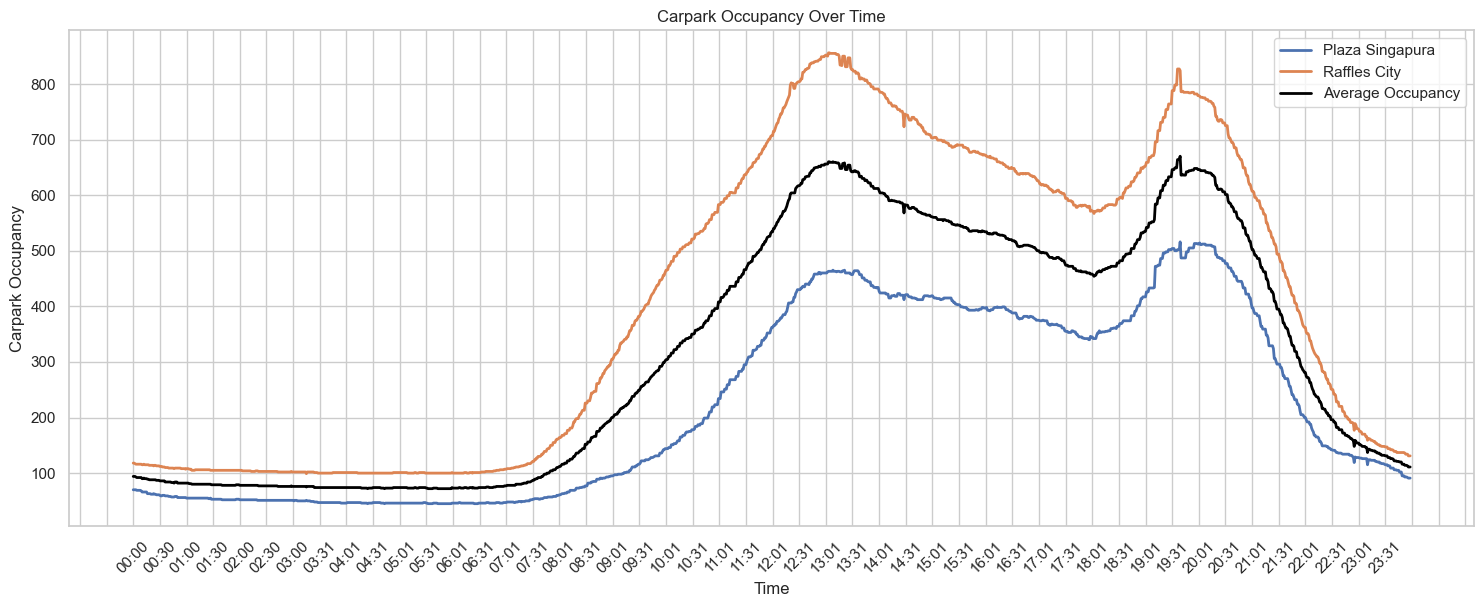

In [322]:
plt.figure(figsize=(15, 6))
for key, data in df_mean_list.items():
    data = data.reset_index()
    plt.plot(
        data["timestamp"],
        data["carparkOccupancy"],
        "-",
        lw=2,
        label=f"{key}",
    )

plt.plot(
    avg_df["timestamp"],
    avg_df["carparkOccupancy_mean"],
    "-",
    lw=2,
    label="Average Occupancy",
    color="black",
)

ax = plt.gca()
loc = plticker.MultipleLocator(base=30.0)
ax.xaxis.set_major_locator(loc)

plt.xlabel("Time")
plt.ylabel("Carpark Occupancy")
plt.title("Carpark Occupancy Over Time")
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### Find the distribution on avg car occupancy


In [351]:
avg_df['carparkOccupancy_diff'] = avg_df['carparkOccupancy_mean'].diff()

# Calculate the car arrival rate as the difference in occupancy divided by the time interval (in minutes)
# You may need to adjust the time interval based on your data's time step
time_interval_minutes = 1  # Assuming the data is in 1-minute intervals
avg_df['car_arrival_rate'] = avg_df['carparkOccupancy_diff'] / time_interval_minutes

# Fill NaN values in the first row with 0 (since there's no previous data to calculate the difference)
avg_df['car_arrival_rate'].fillna(0, inplace=True)
# Now, your DataFrame 'avg_df' will contain the car arrival rate as a new column
avg_df[["carparkOccupancy_mean","car_arrival_rate"]].loc["00:00":"07:00"]
avg_df['car_arrival_rate'] = avg_df['car_arrival_rate'].clip(lower=0)

arrival_df = avg_df[["timestamp","car_arrival_rate"]].copy()


- 1st slice: 0 to 6 Hours  
- 2nd slice: 6 to 14 Hours
- 3rd slice: 14 to 18 Hours
- 4th slice: 18 to 24 Hours

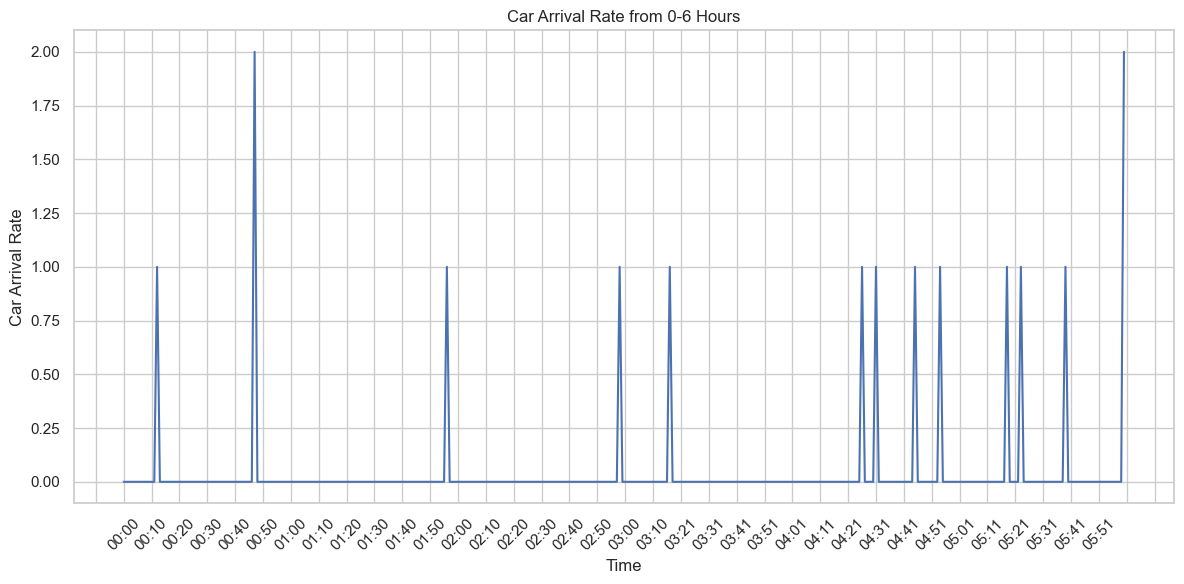

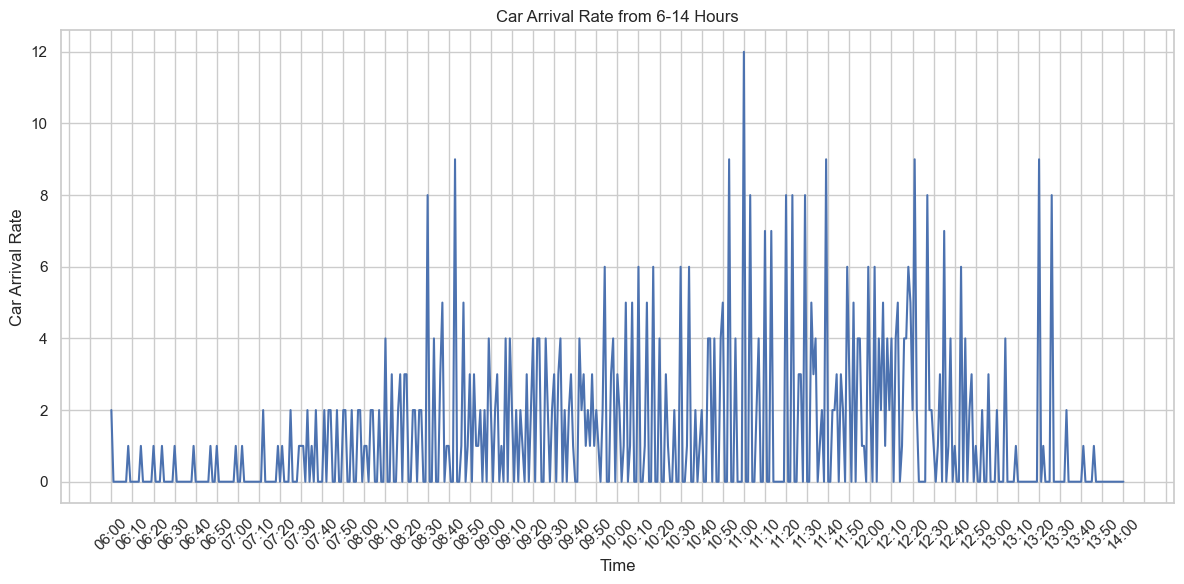

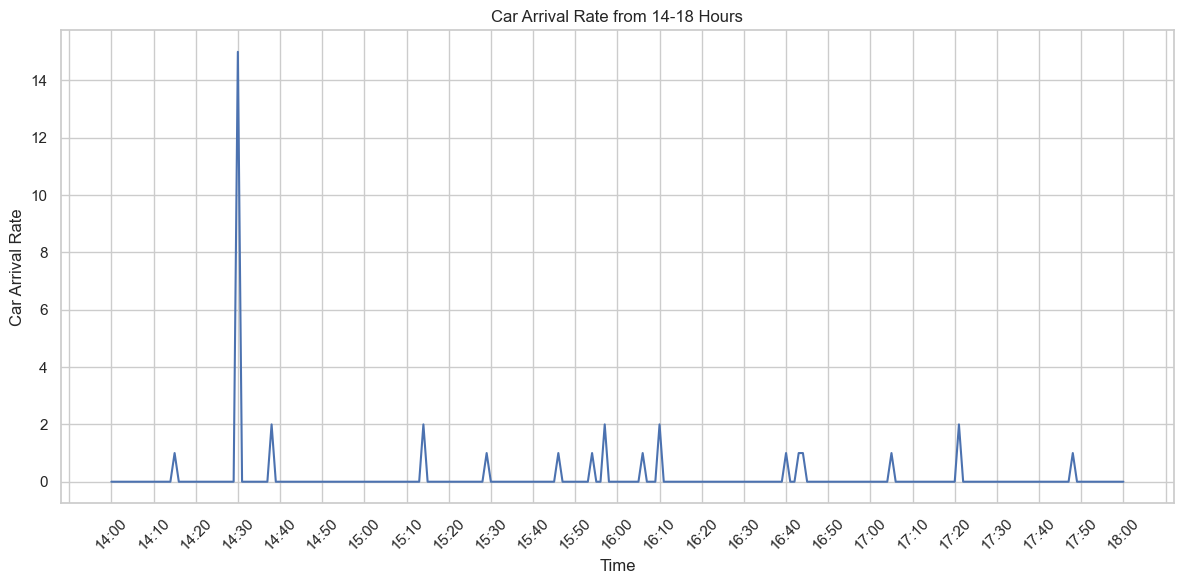

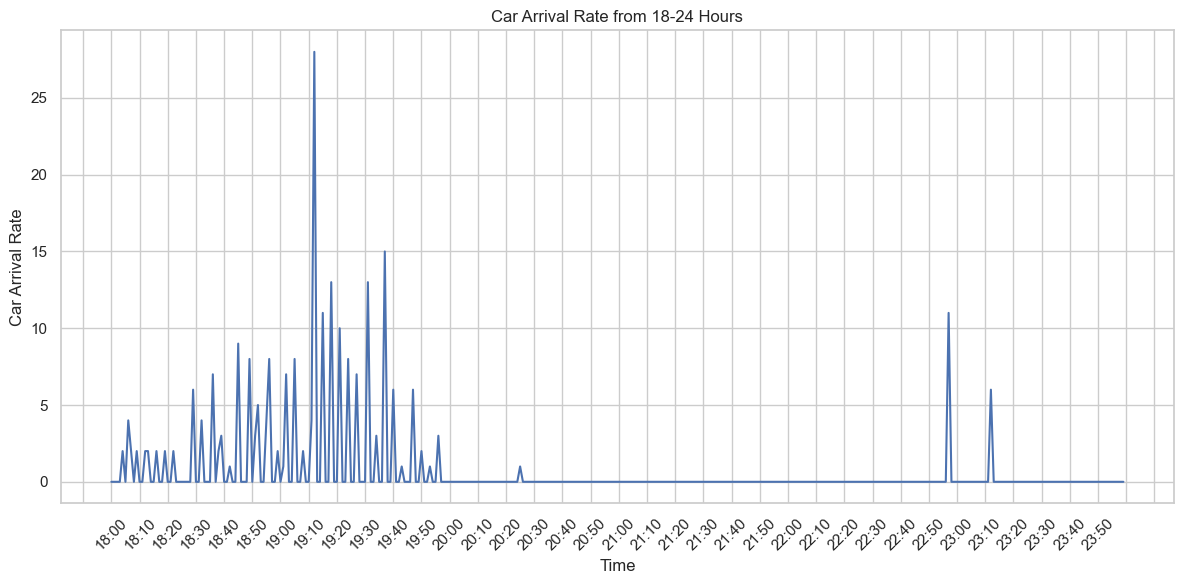

In [377]:
from os.path import join
# Define the time slices
time_slices = [
    ("0-6 Hours", ("00:00", "06:00")),
    ("6-14 Hours", ("06:00", "14:00")),
    ("14-18 Hours", ("14:00", "18:00")),
    ("18-24 Hours", ("18:00", "24:00"))
]

# Create subplots and save CSV files for each time slice
for slice_name, (start_time, end_time) in time_slices:
    # Filter the DataFrame for the current time slice
    mask = (arrival_df['timestamp'] >= start_time) & (arrival_df['timestamp'] <= end_time)
    sliced_df = arrival_df[mask]

    # Create a new subplot
    plt.figure(figsize=(12, 6))
    plt.plot(sliced_df["timestamp"], sliced_df['car_arrival_rate'])
    plt.title('Car Arrival Rate from %s' % slice_name)
    plt.xlabel('Time')
    plt.ylabel('Car Arrival Rate')
    plt.xticks(rotation=45)
    
    ax = plt.gca()
    loc = plticker.MultipleLocator(base=10.0)
    ax.xaxis.set_major_locator(loc)
    
    plt.grid(True)
    plt.tight_layout()
    
    # Save the current subplot as a CSV file
    csv_filename = f"{slice_name}.csv"
    sliced_df.to_csv(join("slices", csv_filename), index=False)
    
    # Show and save the current subplot
    plt.show()
